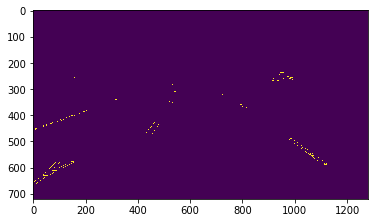

Done


In [3]:
import cv2
import numpy as np
import math
import matplotlib.pyplot as plt

img = "test24.jpg"

pic = cv2.imread(img, 1)

hsv = cv2.cvtColor(pic, cv2.COLOR_RGB2HSV)

B = np.zeros((pic.shape), np.uint8)

g = np.zeros(pic.shape)



#Gaussian Filter

sigma = 2

T=0.3

sHalf = round(math.sqrt(-math.log(T) * 2 * sigma**2)) 

[X, Y]=np.mgrid[-sHalf:sHalf+1, -sHalf:sHalf+1]

#print(X)

#print(Y)

k = (1/(sigma*np.sqrt(2*np.pi)))*(np.exp(-(X**2 + Y**2)/(2*(sigma**2))))

k = k / np.sum(k);


def convolve2d(image, kernel): #function for convolution
    
    kernel = np.flipud(np.fliplr(kernel))  #flips the filter/kernel
    image_h = image.shape[0]
    image_w = image.shape[1]
    
    kernel_h = kernel.shape[0]
    kernel_w = kernel.shape[1]
    
    h = kernel_h//2
    w = kernel_w//2
    
    image_conv = np.zeros(image.shape)
    
    for i in range(h, image_h - h):
        for j in range(w, image_w - w):
            sum = 0
            
            for m in range(kernel_h):
                for n in range(kernel_w):
                    sum = sum + kernel[m][n] * image[i-h+m][j-w+n] #sum of multiplication of the filter to the image
                    
            image_conv[i][j] = sum
    
    
    return image_conv

g = convolve2d(hsv, k)


#Colour Ranges through HSV

step3 = cv2.imread(img, 1)

for y in range(step3.shape[0]):
        for x in range(step3.shape[1]):
            step3[y,x] = 0     
        
g = np.round(g)

def colourRanging(g, g_copy):
    for y in range(g.shape[0]):
        for x in range(g.shape[1]):
            if g[y,x][0] in range(95,110) and g[y,x][1] in range(50,150): #yellow
                g_copy[y,x] = pic[y,x]
            if g[y,x][0] in range(0, 100) and g[y,x][1] in range(0,30) and g[y,x][2] in range(180,255): #white
                g_copy[y,x] = pic[y,x]
                
    return g_copy

step3 = colourRanging(g, step3)

Ig = cv2.cvtColor(step3, cv2.COLOR_BGR2GRAY)

edges = cv2.Canny(Ig,50,150)

#cv2.imwrite('test3_edges.jpg', edges)

plt.imshow(edges)
plt.show()


n = 0

bol = 0


#Region of Interest

for y in range(edges.shape[0]):
        for x in range(edges.shape[1]):
            if y in np.arange(0, 4) or x in np.arange(0, 4):
                edges[y,x] = 0
            if y in np.arange(edges.shape[0] - 4, edges.shape[0]) or x in np.arange(edges.shape[1] - 4, edges.shape[1]):
                edges[y,x] = 0

def rio(edges):               
    height_factor = 2.8

    top_w_r = 100

    top_w_l = 80

    bottom_w_r = 500

    bottom_w_l = 700

    a1 = np.array( [[[0 ,0], [0 ,np.round(edges.shape[0]/height_factor)], [edges.shape[1],np.round(edges.shape[0]/height_factor)],[edges.shape[1],0] ]], dtype=np.int32 )
    
    cv2.fillPoly( edges, a1, 0)

    

    a2 = np.array( [[[0 ,np.round(edges.shape[0]/height_factor)], [0 ,edges.shape[0]], [np.round(edges.shape[1]/2) - bottom_w_r   ,edges.shape[0]], [np.round(edges.shape[1]/2) - top_w_r   ,np.round(edges.shape[0]/height_factor)]]], dtype=np.int32 )

    cv2.fillPoly( edges, a2, 0)

    

    a3 = np.array( [[[np.round(edges.shape[1]/2) + top_w_l   ,np.round(edges.shape[0]/height_factor)], [np.round(edges.shape[1]/2) + bottom_w_l    ,edges.shape[0]], [edges.shape[1],edges.shape[0]], [edges.shape[1],np.round(edges.shape[0]/height_factor)]]], dtype=np.int32 )

    cv2.fillPoly( edges, a3, 0)
    
    return edges

edges = rio(edges)



#Hough transform

hough = edges.copy()

def hough_transform(img):

    thetas = np.deg2rad(np.arange(-90.0, 90.0))
    width, height = img.shape
    diag = int(round(np.sqrt((width**2) + (height**2))))
    rhos = np.linspace(-diag, diag, diag * 2)

    thetas_len = len(thetas)
    
    accumulator = np.zeros((int(2 * diag), thetas_len), dtype=np.uint8)
    y_idx, x_idx = np.nonzero(img)
    
    cos_theta = np.cos(thetas)
    sin_theta = np.sin(thetas)

    for i in range(len(x_idx)):
        x = x_idx[i]
        y = y_idx[i]
        for j in range(thetas_len):
            rho = diag + int(round(x * cos_theta[j] + y * sin_theta[j]))
            accumulator[rho, j] = accumulator[rho, j] + 1

    return accumulator, thetas, rhos

    
accumulator, thetas, rhos = hough_transform(hough)



# linear Regression

hough_copy = np.zeros(hough.shape)

counter = 0
idx = 0
r_max = 0
l_max = 0
r_idx = 0
l_idx = 0
for n in range(accumulator.shape[0]):
    idx = counter
    idx_add = np.argmax(accumulator[n])
    idx = idx_add + idx
    c = int(idx % accumulator.shape[1])
    d = int(idx / accumulator.shape[1])

    if((np.rad2deg(thetas[c])) in range(45, 70)):
        if(np.amax(accumulator[n]) > l_max):
            l_max = np.amax(accumulator[n])
            l_idx = idx
    
    if((np.rad2deg(thetas[c])) in range(-90, -45)):
        if(np.amax(accumulator[n]) > r_max):
            r_max = np.amax(accumulator[n])
            r_idx = idx
        
    counter = counter + 180

    
rho = rhos[int(r_idx/accumulator.shape[1])]
theta = thetas[int(r_idx % accumulator.shape[1])]

a = np.cos(theta)
b = np.sin(theta)
line1_x0 = a*rho
line1_y0 = b*rho
line1_x1 = int(line1_x0 + 1000*(-b))
line1_y1 = int(line1_y0 + 1000*(a))
line1_x2 = int(line1_x0 - 1000*(-b))
line1_y2 = int(line1_y0 - 1000*(a))

rho = rhos[int(l_idx/accumulator.shape[1])]
theta = thetas[int(l_idx % accumulator.shape[1])]

a = np.cos(theta)
b = np.sin(theta)
line2_x0 = a*rho
line2_y0 = b*rho
line2_x1 = int(line2_x0 + 1000*(-b))
line2_y1 = int(line2_y0 + 1000*(a))
line2_x2 = int(line2_x0 - 1000*(-b))
line2_y2 = int(line2_y0 - 1000*(a))

cv2.line(hough_copy,(line1_x1,line1_y1),(line1_x2,line1_y2),255,2)

cv2.line(hough_copy,(line2_x1,line2_y1),(line2_x2,line2_y2),255,2)


hough_copy = rio(hough_copy)

    
for y in range(pic.shape[0]):
    for x in range(pic.shape[1]):
        if(hough_copy[y,x] == 255):
                hough[y,x] = 255
                pic[y,x] = [0, 0, 255]
    
    
cv2.imwrite('test24_hsv.jpg', hsv)

cv2.imwrite('test24_filtered.jpg', step3)

cv2.imwrite('test24_roi.jpg', edges)

cv2.imwrite('test24_houghtransform.jpg', hough_copy)

cv2.imwrite('test24_houghtransform_on_rio.jpg', hough)

cv2.imwrite('test24_output.jpg', pic)


print("Done")